<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/%EC%8B%9C%EA%B3%84%EC%97%B4_Arima_%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0_%EC%A1%B0%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA 차분 파라미터 조정

## 데이터 로드

In [2]:
!pip install finance-datareader

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
# 주식가격 로딩
import FinanceDataReader as fdr

# 삼성전자 2018년 이후
end_date = datetime.datetime.now().strftime("%Y%m%d")
samsung_df = fdr.DataReader('005930', start = '20180101', end = end_date)

samsung_df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2018-01-02,51380,51400,50780,51020,169485,0.001177
2018-01-03,52540,52560,51420,51620,200270,0.011760
2018-01-04,52120,52180,50640,51080,233909,-0.010461
2018-01-05,51300,52120,51200,52120,189623,0.020360
2018-01-08,52400,52520,51500,52020,167673,-0.001919
...,...,...,...,...,...,...
2021-09-07,77100,77100,75900,76100,13239401,-0.015524
2021-09-08,76000,76400,75600,76300,11798147,0.002628
2021-09-09,76400,76600,75000,75300,17600770,-0.013106


In [4]:
df1 = samsung_df[['Close']]
df1 = df1.reset_index()
df1

,Date,Close
0,2018-01-02,51020
1,2018-01-03,51620
2,2018-01-04,51080
3,2018-01-05,52120
4,2018-01-08,52020
...,...,...
908,2021-09-07,76100
909,2021-09-08,76300
910,2021-09-09,75300
911,2021-09-10,75300


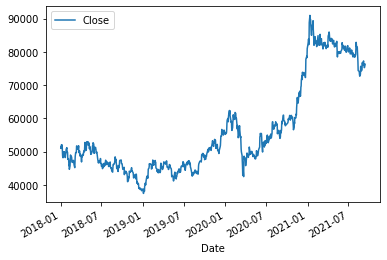

In [5]:
df1.plot('Date','Close')

## ARIMA 모수 설정

In [6]:
df1.columns = ['Date', 'Price']

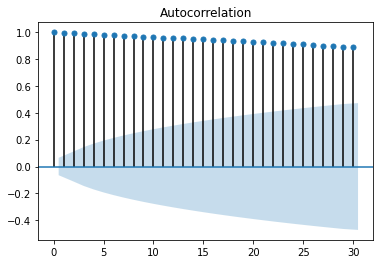

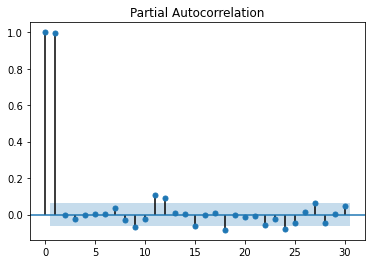

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df1.Price)
plot_pacf(df1.Price)
plt.show()

ACF를 보면 완만하지만 꾸준히 줄어드는 것으로 보인다. 또한 PACF는 1의 Time lag에서 약 0.99를 보이고 이후에 급격히 감소한다.

In [8]:
# 시계열 정상성 검정 Augmented Dickey-Fuller Test
# 비정상성 확인

from statsmodels.tsa.stattools import adfuller
result = adfuller(df1['Price'])

print(f'ADF statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF statistic: -0.5569406214310959
p-value: 0.880417913118139


1차 차분 및 로그변환

In [9]:
x = df1['Price'].values
x = np.log(x)

diff = x[1:] - x[:-1] # 차분

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


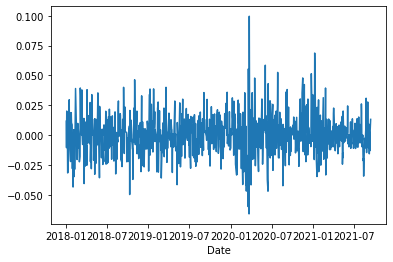

In [10]:
sns.lineplot(df1.iloc[1:, 0], diff)

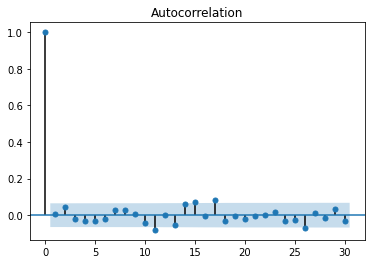

In [11]:
fig = plot_acf(diff)

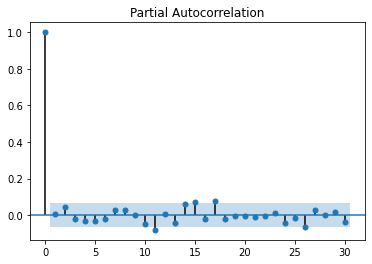

In [12]:
fig = plot_pacf(diff)

In [13]:
result_r = adfuller(diff)

print(f'ADF statistic: {result_r[0]}')
print(f'p-value: {result_r[1]}')  # 1차 차분만으로도 유효한 결과가 나옴

ADF statistic: -30.033008581502763
p-value: 0.0


In [27]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
# 1,0,1 // 1,1,1 // 1,2,1 // 1,2,2 // 2,2,2 // .... 여러가지 차수를 지정해봤을 때 2,1,2가 최적임
# (AR = 2, 차분 =1, MA=2) 파라미터로 ARIMA 모델을 학습한다.
model = ARIMA(df1.Price.values, order = (2,1,2))
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  912
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -7538.858
Method:                       css-mle   S.D. of innovations            938.892
Date:                Mon, 13 Sep 2021   AIC                          15089.716
Time:                        08:45:47   BIC                          15118.609
Sample:                             1   HQIC                         15100.746
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.7394     31.285      0.439      0.661     -47.577      75.056
ar.L1.D.y     -1.5979      0.012   -138.725      0.000      -1.620      -1.575
ar.L2.D.y     -0.9802      0.009   -113.114      0.0

In [28]:
# const 가 유의하지 않으므로 trend를 nc로해서 다시 모델 적합
model = ARIMA(df1.Price.values, order = (2,1,2))
model_fit = model.fit(trend = 'nc', full_output = True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  912
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -7539.154
Method:                       css-mle   S.D. of innovations            939.200
Date:                Mon, 13 Sep 2021   AIC                          15088.309
Time:                        08:45:53   BIC                          15112.387
Sample:                             1   HQIC                         15097.501
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y     -1.5978      0.011   -139.518      0.000      -1.620      -1.575
ar.L2.D.y     -0.9801      0.009   -113.423      0.000      -0.997      -0.963
ma.L1.D.y      1.5997      0.008    208.092      0.0

In [29]:
# 학습, 테스트 데이터 분리
train = df1[:-10]
test = df1[-10:-1]

In [30]:
model = ARIMA(train.Price.values, order = (2,1,2))
model_fit = model.fit(trend = 'nc', full_output = True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  902
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -7455.896
Method:                       css-mle   S.D. of innovations            938.511
Date:                Mon, 13 Sep 2021   AIC                          14921.792
Time:                        08:45:56   BIC                          14945.815
Sample:                             1   HQIC                         14930.968
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y     -1.5984      0.011   -142.002      0.000      -1.620      -1.576
ar.L2.D.y     -0.9798      0.009   -111.293      0.000      -0.997      -0.963
ma.L1.D.y      1.6004      0.007    225.638      0.0

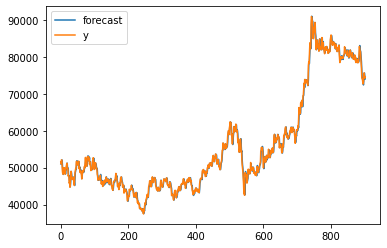

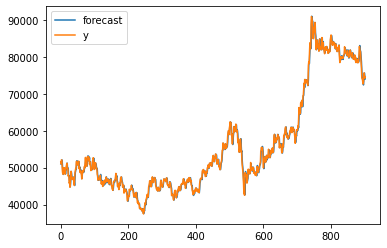

In [31]:
model_fit.plot_predict()

In [32]:
fore = model_fit.forecast(steps=1)
print(fore)

(array([74816.33979261]), array([938.51116082]), array([[72976.89171831, 76655.78786691]]))


In [33]:
df1[-1:]

,Date,Price
912,2021-09-13,76300


예측값 --> 74816.3 // 실제값 76300 